In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/Homework2

Mounted at /gdrive
/gdrive/My Drive/Homework2


In [2]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [3]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.15.0


In [4]:
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler

## Import data
Loading the data and checking the shapes.
Building the X and y sets for training and testing.
Reshaping in order to match the sizes of the architecture.

In [5]:
dataset = np.load('training_data.npy')
periods = np.load('valid_periods.npy')
cat = np.load('categories.npy')
print(dataset.shape)
print(periods.shape)
print(cat.shape)

(48000, 2776)
(48000, 2)
(48000,)


In [7]:
# Building X and y sets: X is made of sequences of length window, and y is the subsequent sequence of length telescope.
X = []
y = []
categories = []    # not needed for this architecture
window = 45
telescope = 9
stride = 10
for i in range(dataset.shape[0]):
  j = periods[i,0]    # starting from this position allows to discard the padding
  while(j+window+telescope < periods[i,1]):    # check that both window and telescope fit in the timeseries
    X.append(dataset[i,j:j+window])
    y.append(dataset[i,j+window:j+window+telescope])
    j = j+stride

In [8]:
X = np.array(X)
y = np.array(y)
X.shape, y.shape

((713619, 45), (713619, 9))

In [10]:
# creating train and test
test_size = int(0.9 * X.shape[0])    # keep 10% of the data for testing
X_train, X_test = np.split(X,[test_size])
y_train, y_test = np.split(y,[test_size])
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(642257, 45) (642257, 9) (71362, 45) (71362, 9)


In [11]:
X_train = np.expand_dims(X_train,axis=2)
X_train.shape

(642257, 45, 1)

In [12]:
y_train = np.expand_dims(y_train,axis=2)
y_train.shape

(642257, 9, 1)

In [13]:
X_test = np.expand_dims(X_test,axis=2)
X_test.shape

(71362, 45, 1)

In [14]:
y_test = np.expand_dims(y_test,axis=2)
y_test.shape

(71362, 9, 1)

In [15]:
del X
del y
del dataset

## Training of the model
Setting input and output shapes, building the architecture and training (training/validation split is 90/10).

In [16]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 400

In [17]:
input_shape, output_shape

((45, 1), (9, 1))

In [18]:
def build_model(input_shape, output_shape):

    # Define the input layers with the specified shape
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # two bidirectional LSTM layers with dropout
    x = tfkl.Bidirectional(tfkl.LSTM(units=64,return_sequences=True, name='lstm1'), name='bilstm1')(input_layer)
    x = tfkl.Dropout(rate=1/8, name='dropout1')(x)
    x = tfkl.Bidirectional(tfkl.LSTM(units=64,return_sequences=True, name='lstm2'), name='bilstms2')(x)
    x = tfkl.Dropout(rate=1/8, name='dropout2')(x)

    # convolutional part
    x = tfkl.Conv1D(128, 3, padding='same', activation='relu', name='conv')(x)
    output_layer = tfkl.Conv1D(output_shape[1], 3, padding='same', name='output_layer')(x)
    crop_size = output_layer.shape[1] - output_shape[0]
    output_layer = tfkl.Cropping1D((0, crop_size), name='cropping')(output_layer)

    # creation and compilation of the model, using adamW with lr=3e-4
    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='CONV_LSTM_model')
    model.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.AdamW(learning_rate=3e-4), metrics=['mae'])

    return model

Model: "CONV_LSTM_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 45, 1)]           0         
                                                                 
 bilstm1 (Bidirectional)     (None, 45, 128)           33792     
                                                                 
 dropout1 (Dropout)          (None, 45, 128)           0         
                                                                 
 bilstms2 (Bidirectional)    (None, 45, 128)           98816     
                                                                 
 dropout2 (Dropout)          (None, 45, 128)           0         
                                                                 
 conv (Conv1D)               (None, 45, 128)           49280     
                                                                 
 output_layer (Conv1D)       (None, 45, 1)         

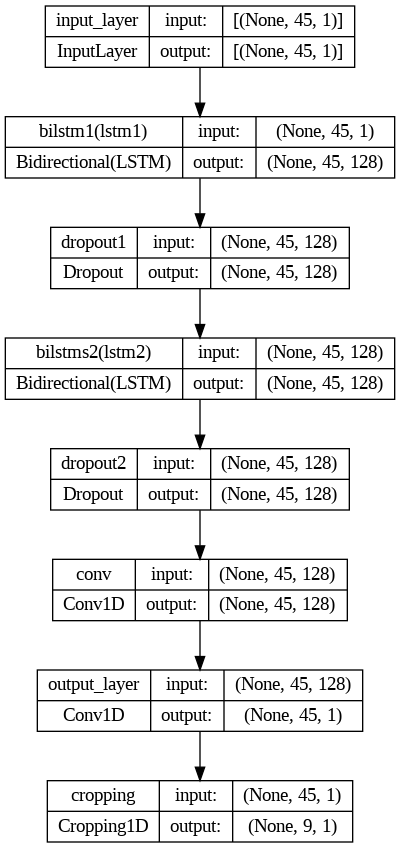

In [19]:
# summary of the built model
model = build_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True, show_shapes=True)

In [20]:
# Train the model
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

Epoch 1/400
9032/9032 [==============================] - 159s 16ms/step - loss: 0.0119 - mae: 0.0749 - val_loss: 0.0074 - val_mae: 0.0554 - lr: 3.0000e-04
Epoch 2/400
9032/9032 [==============================] - 140s 15ms/step - loss: 0.0093 - mae: 0.0651 - val_loss: 0.0067 - val_mae: 0.0528 - lr: 3.0000e-04
Epoch 3/400
9032/9032 [==============================] - 141s 16ms/step - loss: 0.0087 - mae: 0.0626 - val_loss: 0.0067 - val_mae: 0.0520 - lr: 3.0000e-04
Epoch 4/400
9032/9032 [==============================] - 138s 15ms/step - loss: 0.0084 - mae: 0.0609 - val_loss: 0.0064 - val_mae: 0.0514 - lr: 3.0000e-04
Epoch 5/400
9032/9032 [==============================] - 139s 15ms/step - loss: 0.0081 - mae: 0.0597 - val_loss: 0.0061 - val_mae: 0.0490 - lr: 3.0000e-04
Epoch 6/400
9032/9032 [==============================] - 141s 16ms/step - loss: 0.0079 - mae: 0.0587 - val_loss: 0.0061 - val_mae: 0.0488 - lr: 3.0000e-04
Epoch 7/400
9032/9032 [==============================] - 136s 15ms/ste

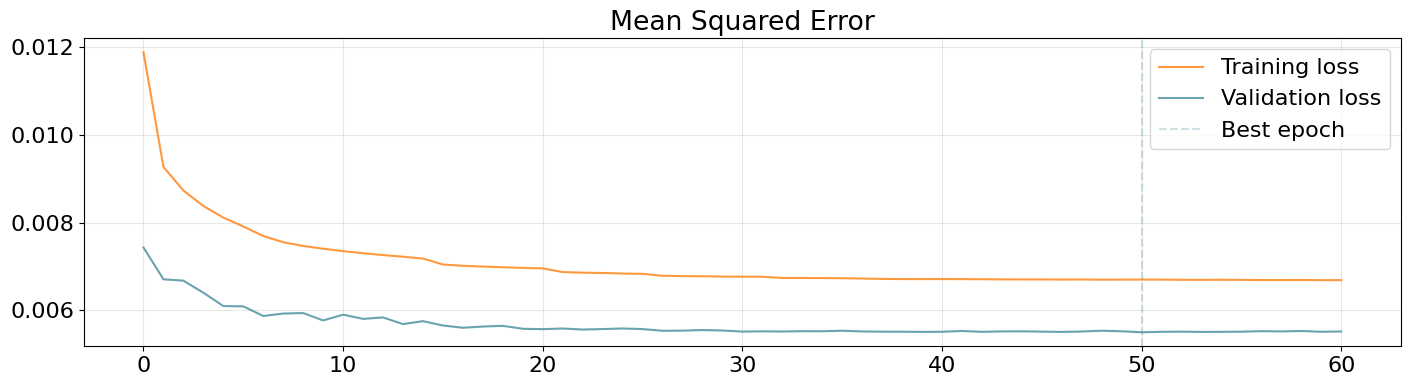

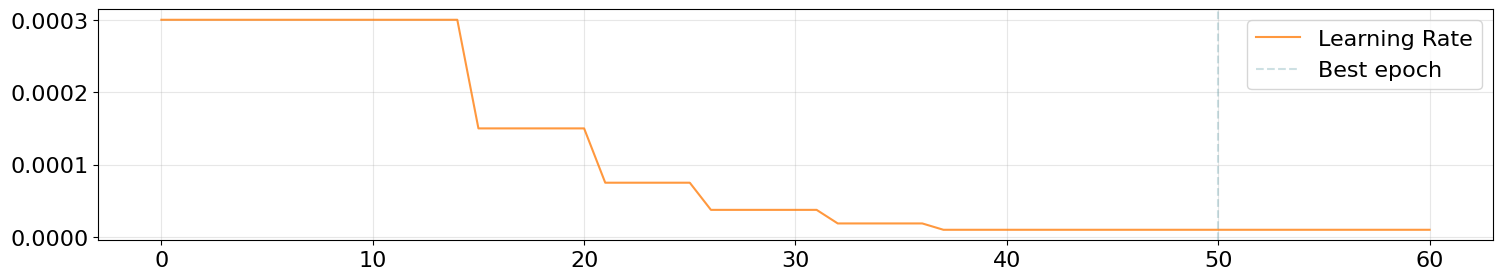

In [21]:
best_epoch = np.argmin(history['val_loss'])
plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

In [22]:
model.save('FinalModel')
del model
model = tfk.models.load_model('FinalModel')

## Inference on test set


In [23]:
# Predict the test set using the model
predictions = model.predict(X_test)

# Print the shape of the predictions
print(f"Predictions shape: {predictions.shape}")

# Calculate and print Mean Squared Error (MSE)
mean_squared_error = tfk.metrics.mean_squared_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Squared Error: {mean_squared_error}")

# Calculate and print Mean Absolute Error (MAE)
mean_absolute_error = tfk.metrics.mean_absolute_error(y_test.flatten(), predictions.flatten()).numpy()
print(f"Mean Absolute Error: {mean_absolute_error}")

2231/2231 [==============================] - 15s 6ms/step
Predictions shape: (71362, 9, 1)
Mean Squared Error: 0.010149778798222542
Mean Absolute Error: 0.06150281801819801


In [24]:
def inspect_multivariate_prediction(X, y, pred, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    plt.plot(np.arange(window), X[idx,:,:])
    plt.plot(np.arange(window,window+telescope), y[idx,:,:], color='orange')
    plt.plot(np.arange(window,window+telescope), pred[idx,:,:], color='green')
    plt.ylim(0,1)
    plt.show()

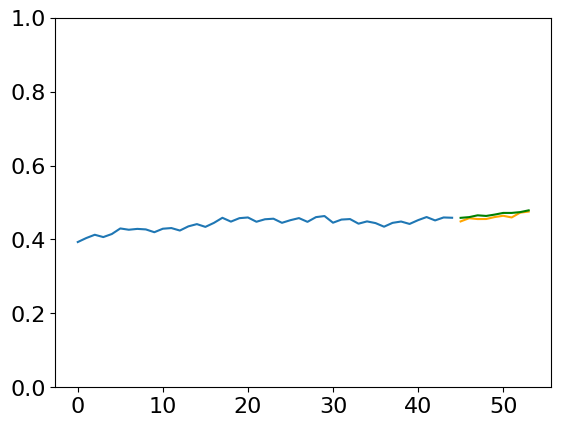

In [179]:
inspect_multivariate_prediction(X_test, y_test, predictions, telescope)
# in orange the ground truth, in green the predictions